## Imports

In [1]:
# Unsere Klassen
import load_data
import preprocess
import testing_models # Use: build_model9v3(img_width, img_height, char) 
import utils.configs as Config
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import random
import time
import os

## Config

In [2]:
config_path = "utils/configs.json"
config = Config.Config(config_path)

# Model Parameter
MODEL_SAVE = bool(config.get_model_parameter()["save"])
MODEL_NAME = config.get_model_parameter()["name"]
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 64

# Directory Parameter
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["model_dir"])
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["test_dir"])
DATA_BASE_PATH = config.get_directory_parameter()["data_base_path"]

# Training Parameter
SAVE_HISTORY = bool(config.get_training_parameter()["save_history"])
EPOCHS = config.get_training_parameter()["epochs"]
BATCH_SIZE = config.get_training_parameter()["batch_size"] # default: 32 - 48
TF_SEED = config.get_training_parameter()["tf_seed"] # default: 42
LEARNING_RATE = config.get_training_parameter()["learning_rate"] * 0.1
PATIENCE = config.get_training_parameter()["patience"] # default: 3

## Load Data

In [3]:
# Default: seed = 42
np.random.seed(TF_SEED)
tf.random.set_seed(TF_SEED)

# Random
#seed = random.randint(1, 1000)
#np.random.seed(seed)
#tf.random.set_seed(seed)
print(LEARNING_RATE)
print(TF_SEED)

0.0001
42


In [4]:
load_data.print_samples(DATA_BASE_PATH)
x_train_img_paths, y_train_labels = load_data.get_train_data()
x_test_img_paths, y_test_labels = load_data.get_test_data()
x_val_img_paths, y_val_labels = load_data.get_validation_data()

Total train samples: 10209
Total validation samples: 567
Total test samples: 568
Maximum length:  93
Vocab size:  79


In [ ]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer
import custom_image_generator as cgi

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)

#train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT)

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
#aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)

## Show Examples

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 4))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

# Data Augmentation

In [ ]:
# To see the augmentations from CustomImageGenerator
train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, tokenizer.batch_size, IMAGE_WIDTH, IMAGE_HEIGHT)

example_batch = train_generator[0]
augmented_images = example_batch[0]['image']

num_to_plot = 4
fig, axes = plt.subplots(1, num_to_plot, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.squeeze(augmented_images[i]), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.5,value_range=(0, 1), seed=TF_SEED),
        tf.keras.layers.RandomContrast(0.5,seed=TF_SEED)
    ]
)

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.imshow(images[0].numpy(), cmap='gray', vmin=0, vmax=1)
plt.title("Original Image")

# Apply data augmentation to the image
augmented_images = data_augmentation(images, training=True)

# Display the augmented images
for i in range(3):
    plt.subplot(1, 4, i + 2)
    plt.imshow(augmented_images[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Augmented Image {i+1}")
    
plt.show()

# Train Keras Model

In [6]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists():
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)


In [7]:
def train_model(model):
    model_load_weights_if_exists()
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    
    checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[checkpoint, early_stopping])    
    return prediction_model, history

In [8]:
# Default
# model = testing_models.build_model_default(IMAGE_WIDTH, IMAGE_HEIGHT, char, MODEL_NAME)

char = len(tokenizer.char_to_num.get_vocabulary())
model = testing_models.build_model9v3(IMAGE_WIDTH, IMAGE_HEIGHT, char, LEARNING_RATE)
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 1024, 64, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 1024, 64, 48  480         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 Conv2 (Conv2D)                 (None, 1024, 64, 96  41568       ['Conv1[0][0]']                  
                                )                                            

In [9]:
start_time = time.time()

prediction_model, history = train_model(model)

total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

c:\Users\Alexej\Desktop\SmartApp-Project\models\model9v3
Epoch 1/200
213/213 [==============================] - 106s 421ms/step - loss: 258.4080 - val_loss: 134.7180
Epoch 2/200
213/213 [==============================] - 81s 381ms/step - loss: 135.4623 - val_loss: 133.5377
Epoch 3/200
213/213 [==============================] - 81s 382ms/step - loss: 134.8831 - val_loss: 133.6344
Epoch 4/200
213/213 [==============================] - 82s 383ms/step - loss: 134.5023 - val_loss: 133.3629
Epoch 5/200
213/213 [==============================] - 82s 383ms/step - loss: 134.1357 - val_loss: 132.8294
Epoch 6/200
213/213 [==============================] - 81s 382ms/step - loss: 133.2973 - val_loss: 130.2533
Epoch 7/200
213/213 [==============================] - 81s 383ms/step - loss: 126.4073 - val_loss: 117.6316
Epoch 8/200
213/213 [==============================] - 82s 384ms/step - loss: 115.5069 - val_loss: 107.5899
Epoch 9/200
213/213 [==============================] - 82s 385ms/step - loss: 

# Plot helper functions


In [10]:
def plot_history(history, name, dir_path, save_fig):
    """
    Plottet die Historie des Trainings eines Models und speichert die in einem Verzeichnis ab 

    :param history: Das trainierte Modell
    :param name: Name, wie das Modell gespeicht werden soll
    :param name: Verzeichniss, wo der Plot gespeichert weren soll
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [11]:
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [12]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [13]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in test_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 4))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

# Model Testing

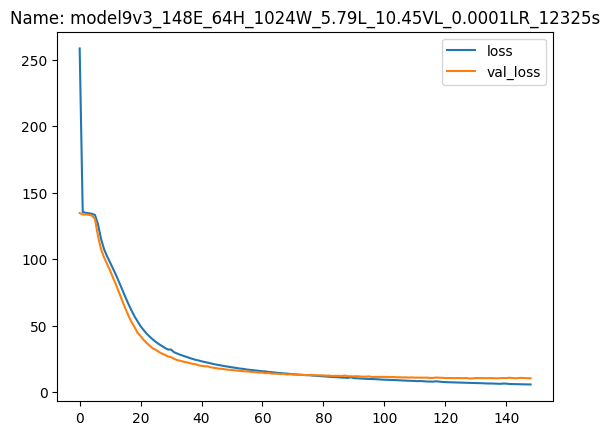

2/2 [==============================] - 0s 42ms/step


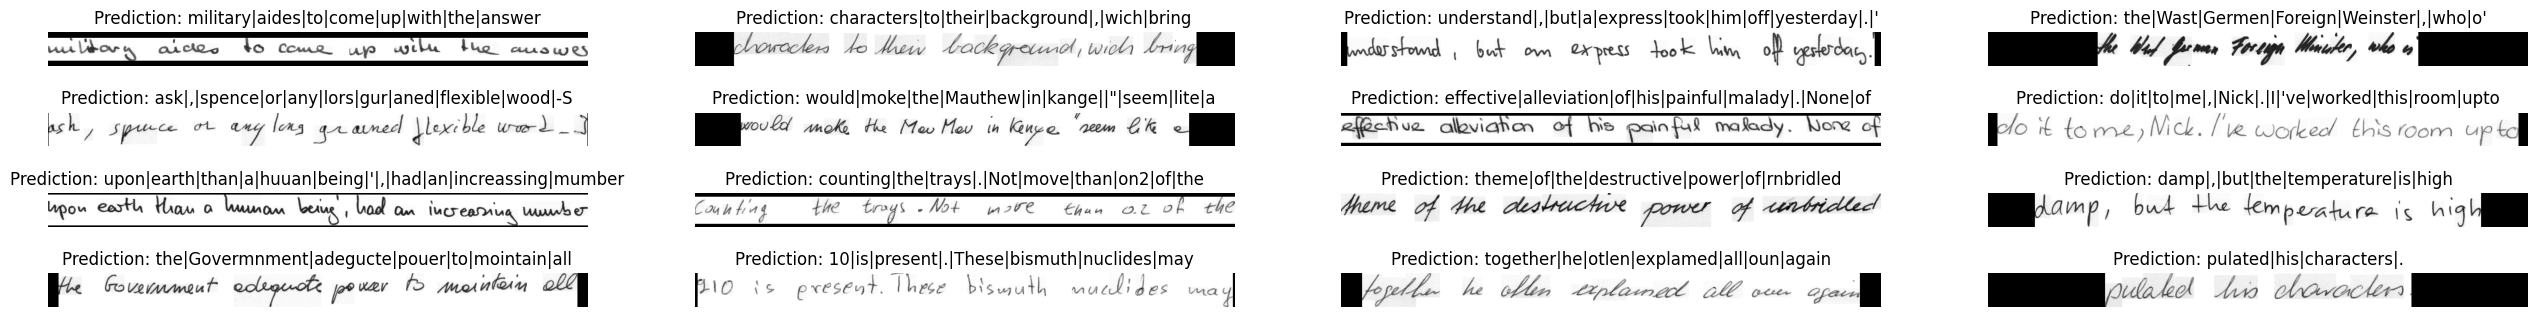

In [15]:
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{lr}LR_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), lr= LEARNING_RATE, time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    plot_history(history, name=None, dir_path=None, save_fig=False)
    plot_evaluation(name=None, dir_path=None, save_fig=False)

# Save the Model

In [16]:
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)

INFO:tensorflow:Assets written to: c:\Users\Alexej\Desktop\SmartApp-Project\models\model9v3\assets


INFO:tensorflow:Assets written to: c:\Users\Alexej\Desktop\SmartApp-Project\models\model9v3\assets
